# The project for this section is: Credit risk scoring
- the bank analyses your information and decides if they should lend you the money or not.
- the bank will use our service to get the risk of defaulting and then get a result
- we will use banking history, including how much they have and whether they can pay back the loan or not
- X is all the info from all the users and Y is the result (OK to loan vs default) g(x) is the probaiblity of defaulting




In [ ]:
# initial setup
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# getting data
df = pd.read_csv("data/CreditScoring.csv")
df.head()

# Data prep and cleaning
- re-encoding the categorieal variables
- train validation testing split


In [ ]:
# the original file already has a bunch of ways to clean the data, so we will just do the same thing here as what they did in the repo

df.columns = df.columns.str.lower()
df.status = df.status.map({1: 'ok', 2: 'default', 0: 'unk'})


In [ ]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [ ]:
df.head()

In [ ]:
df.describe().round()

In [ ]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)
df.describe().round()


In [ ]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [ ]:
# Split the data like usual

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_train['status']
del df_val['status']
del df_test['status']

df_train

# Decision Trees
- it is a tree where if it is true go right, else we go left. Then the bottom is the decision we make based onthe previous if-else conditions

===
- we can make them in if 
- training a tree
- overfitting
- controlling size of a tree

In [ ]:
# example of a decision tree, just a bunch of if else statements.


def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [ ]:
# now lets use it on the first record 
xi = df_train.iloc[0].to_dict()
assess_risk(xi)

In [ ]:
# now we can make this tree from our data

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score


# train the dv so we get the feature matrix
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# train our decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

In [ ]:
# use the validation dataset

val_dicts = df_val.fillna(0).to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = dt.predict_proba(X_val)[:, 1]

In [ ]:
# get the ROC accuracy score
roc_auc_score(y_val, y_pred)

# its not impressive

If we run the roc_auc_score for the training dataset, we get a value of 1. This is called overfitting
- overfitting means it memorizes the data, but it is clueless and does not know how to generalize
- with the rule made, it is very possible that it is very specific to each customer. This allows it to memroize the data therefore overfitting
- If our tree grows too deep, this makes it more likely to meorize. The better approach is to have a smaller depth so it learns rules

lets try that below

In [ ]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

# if depth is 1, then it is called a decision stump

In [ ]:
# now lets get the tree
from sklearn.tree import export_text

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))


# Decision tree learning algorithm

- finding the best split for one column
- finding the best split for the entire dataset
- stoping criteria
- decision tree learning algo

So in a decision tree, there are condition nodes and it can be a feature with a threshold. 
To learn how it works, les start with a simple dataset

In [ ]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

In [ ]:
# we want to use the assets column to trian, so assets > a threshold T, and the decision is based off of that
# this splits the dataset where the df_right is where it is true, and df_left is where it is false
df_example.sort_values('assets')

In [ ]:
# lets try a couple of thresholds
Ts = [0, 2000, 3000, 4000, 5000, 8000]

for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print("_____")


In [ ]:
# this lets us evaluate it. The number of errors is the misclassification rate

T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))
# here we have one of four in the left and 1 of 4 in right. so 25% in both. the misclassification rate is the impurity

the impurity table has the following columns
- T (threshold)
- decision left
- impurity left
- decision right
- impruity right
- average

the row with the lowest average is the t value that is the best

To handle it when there are 2 features:

In [ ]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

In [ ]:
df_example.sort_values('debt')


In [ ]:
# because we have more features, we will also need more thresholds

thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [ ]:
# now we iterate over each of them 

for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

to find the best feauture, we just have a loop where:
- for each feature F we find all threasholds for that F
    - then for T in thresholds of that feature, we split the dataset and compute the impurity


- then we select the condition with the lowest purity and use that in our decision tree

how do we find the condition to stop? 

- well if the group is already pure, then there is no point in splitting that group.
- also if it reaches the max-depth parameter, we will stop
-  if a group is too small, we also stop and won't split. This depends on the minimum size parameter

# Decision tree parameter tuning
we will need to decide the parameters that we learned form last section. there are more parameters out there but these are the two important ones.
- selecting max_depth
- selecting min_samples_leaf (how many sampels per leaf)

In [ ]:
# lets try different depths

depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))
    
# we can say that 4-6 have the highest scores. Now for those values we can see the different min-value-leaf values

In [ ]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))




In [ ]:
# we can put it in a df so that it is easier to read

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

# now we can see that 

In [ ]:
# now we can visualize it in a heatmap with seaborn
# we can see tha the lightest cell is the highest

sns.heatmap(df_scores_pivot, annot=True, fmt = '.3f')

In [ ]:
# if a dataset is big so we cannot try every combo, so we get max depth first then max fatures
# now lets get the final decision tree

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

# Ensembles and random forest
- board of experts
- ensembling models
- ranodm forest -- ensembling decision trees
- tuning random forest

### board of experts
- so imagine where we don't have the tree on the recieving end, instead we have a board of experst that vote. 
- the same idea can be applied to models. so each model can provide a probaility, and we take the decisions and aggregate them. 
- If the models in the board of experts, then it is called a random forest algorithm
- each tree gets a different set of features to make the trees different


so to summarize:
- each decision tree gets a different set of weights from the original dataframe
- then we get the average of them



In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

In [ ]:
scores = []

# lets test out multiple n values. 
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

# now lets plot the results
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)



we can see that the score grows until around 50 and then staginates. This means that the most optimal way is to have the n as 50 and it does not make sense ot use more compute and train more trees

now lets tune the decision tree parameters (max depth and min leaf size)

In [ ]:
# lets start with the depth

scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))
        
    
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

So we can see that dpeth actually matters and 10 is the most optimal, then now lets move on the min leaf size

In [ ]:
max_depth = 10
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))
        
        
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

So now we can see that 3 is the most optimal. Now lets do the final model

In [ ]:
min_samples_leaf = 3


rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

another param one you can tune is the max_features but we are not doing it here. Basically it is the amount of features for each tree in the random forest.

Another way is to do bootstraping, the param is bootstrap = true or false. basically each tree gets a bootstrap sample drawn with replacement from the original data.

bagging aggregates the results of bootstrapping

n_jobs param is the number of trees trained in parallel, -1 means all in parallel

# Gradient boosting and XGBoost
- gradient boost vs ranodm forest
- using xgboost to train a model
- performance monitoring
- parsing xgboost's monitoring output

- so random forest has multiple independent trees, but boosting does it differently
- we would train a model which has errors, then we would train a second model to correct and improve, then it continues until at the end we get a final prediciton
- we sequentially trian multiple models, and each model improves upon the previous one

In [ ]:
import xgboost as xgb

In [ ]:
# xgboost likes a DMatrix. it takes the feature matrix, target variable, and then also the lables

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
# the train funciton requreis lots of params, then we will use the train variable

# the important ones are eta (how fast our modle learns), max depth (default 6), max child weight (min sample leaf)
# then we have objective which we use binary-logistic meaning that we have 2 results and we use a sigmoid. nthread is the number of threads used

# then seed is the random seed and verbosity shows warnings (1 means show)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [ ]:
# now lets test this model
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)
#80 is pretty good with default params

xgboost is pretty prone to overfitting, so we need to be careful how many "tiers" we train

we are actually able to check each iteration and see how it is with our valiation data. so to do this we need a watchlist

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
s = output.stdout
print(s[:200])


now lets plot the performance

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
df_score = parse_xgb_output(output)


In [ ]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [ ]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# XGboost parameter tuning
we will tune the following parameters:
- eta
- max_depth
- min_child_weight

### eta:
- eta is the learning rate. 
- how much each new tree contributes to the model. Low means slower learning but better generalization. higher eta might risk overfitting

In [117]:
scores = {}

In [91]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [116]:
scores.keys()

dict_keys(['min_child_weight=30'])

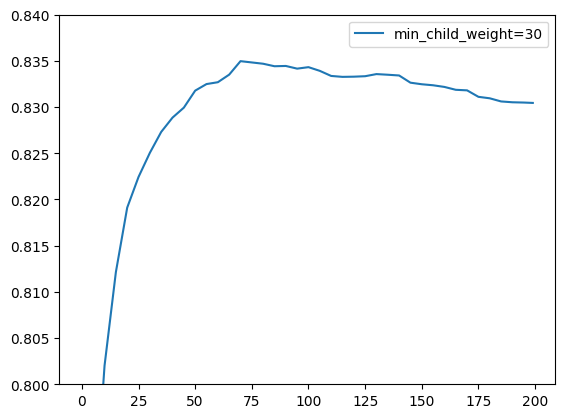

In [115]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

we can see that there are some that perform better than others, but it may take more iterations. 

some models learn faster but overfits when it has too much iteration, and some learns slow but has a good result

##### tuning order
we usually go eta then max depth then min child weight

In [130]:
scores = {}


In [137]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [138]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

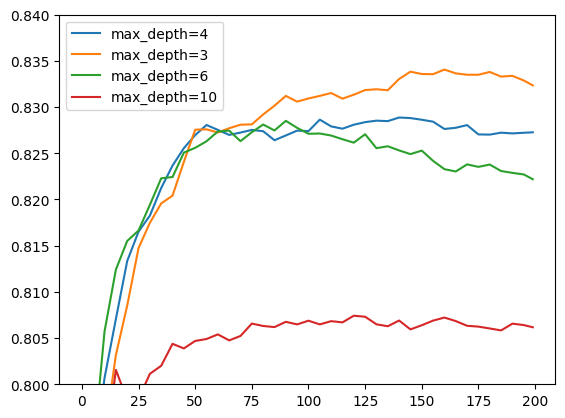

In [139]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

we can see that with a lower max depth, sometimes it is less prone to overfitting and keeps growing, however it takes more iterations

In [140]:
# now lets do matx iteration 

scores = {}



In [151]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [152]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

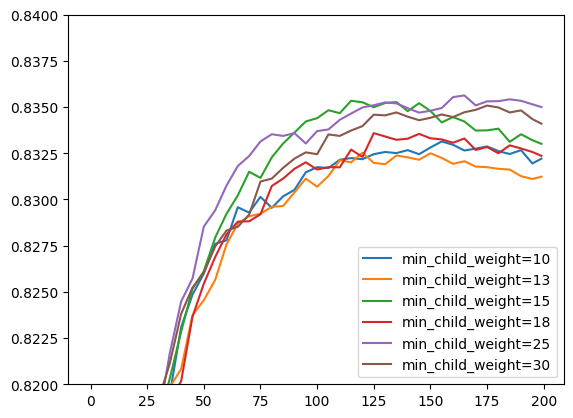

In [153]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

we can see that the difference is not THAT big. 175 seem slike the sweet spot for iterations 

now lets train the optimal model



In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

`subsample` and `colsample_bytree`
`lambda` and `alpha`

# Selecting the final model
- choosing between xgboost random forest and decision tree
- training the final model
- saving the model

In [154]:
# lets take our best models

# decision tree

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850802838390931

In [155]:
# random forest

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)\
    
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [156]:
# xgboost
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8334715797631446

In [157]:
# we can see that xgboost is the best, so we use that with our fulltrain dataset and then test it
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']




In [163]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)



In [ ]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

TypeError: Expecting a sequence of strings for feature names, got: <class 'numpy.ndarray'>

In [165]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

NameError: name 'dfulltrain' is not defined

In [166]:
y_pred = model.predict(dtest)

NameError: name 'dtest' is not defined

In [167]:
roc_auc_score(y_test, y_pred)


0.5058984164996823